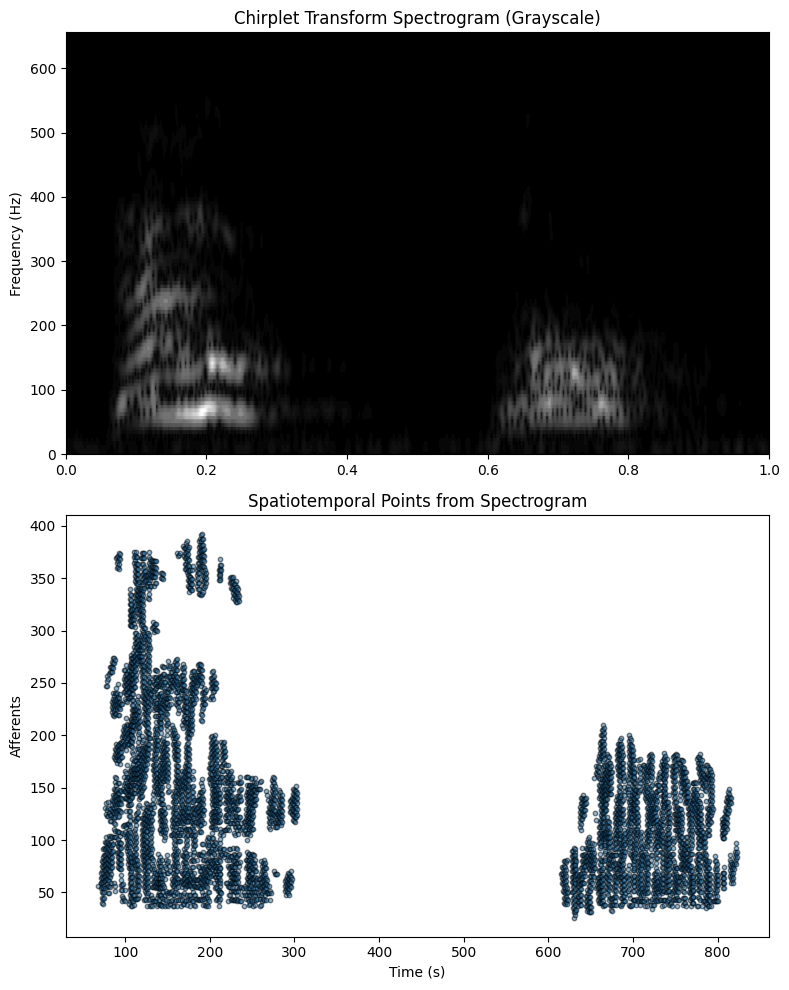

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from brian2 import *

# Load the chirplet transform spectrogram PNG image using OpenCV
image_path = 'test.png'  # Path to the uploaded image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Convert image to float and normalize
image_data = image.astype(float) / 255.0

# Get the dimensions of the image
height, width = image_data.shape

# Parameters
time_duration = 1.0 * second  # Total time duration of the spectrogram
num_neurons = height  # Number of neurons equals the number of frequency bins

# Adjust the global threshold
global_threshold = 0.3  # Manually adjust this value to capture more or fewer points

# Adaptive thresholding using OpenCV
block_size = 25  # Adjust the block size, must be an odd number
C = -1  # Adjust the constant subtracted from the mean or weighted mean

adaptive_thresh = cv2.adaptiveThreshold((image_data * 255).astype(np.uint8), 255, 
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)
adaptive_thresh = adaptive_thresh / 255.0  # Normalize back to 0-1 range

# Extract spatiotemporal points from the image data using adaptive threshold
times = []
neurons = []

for x in range(width):
    for y in range(height):
        if image_data[y, x] > global_threshold and adaptive_thresh[y, x] > 0:
            time_point = x / width * time_duration
            neuron_point = y
            times.append(time_point)
            neurons.append(neuron_point)

# Convert times to a Brian2 quantity with units of time
times = np.array(times) * second
neurons = np.array(neurons, dtype=int)

# Define a NeuronGroup in Brian2
G = NeuronGroup(num_neurons, 'v : 1', threshold='v>1', reset='v=0', method='exact')
G.v = 0  # Initialize all membrane potentials to 0

# Create a SpikeGeneratorGroup based on the extracted spatiotemporal points
input_group = SpikeGeneratorGroup(num_neurons, indices=neurons, times=times)

# Synapses to drive the neuron group
S = Synapses(input_group, G, on_pre='v_post += 1')
S.connect(j='i')

# Run the simulation
run(time_duration)

# Plot the results
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plot the original spectrogram in grayscale and invert y-axis
axes[0].imshow(image_data, aspect='auto', origin='upper', cmap='gray', extent=[0, time_duration/second, 0, height])
axes[0].set_ylabel('Frequency (Hz)')
axes[0].set_title('Chirplet Transform Spectrogram (Grayscale)')

# Downsample points to reduce clutter
sampling_factor = 5  # Adjusted to retain more points
sampled_indices = np.arange(0, len(times), sampling_factor)

# Plot the generated spatiotemporal points with transparency and borders
axes[1].scatter(times[sampled_indices]/ms, num_neurons - neurons[sampled_indices] - 1, s=10, alpha=0.5, edgecolor='black')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Afferents')
axes[1].set_title('Spatiotemporal Points from Spectrogram')

plt.tight_layout()
plt.show()